# YOLO Plant Anomaly Detection & Fainting persons detection Model Demo 
## Detecting Healthy vs Diseased Plants
## Detecting Fainted vs Non fainted person

**A YOLO model trained to detect:**
- Plant anomalies (healthy vs diseased plants)
- Detecting Fainted vs Non fainted person

**Model Performance:**
- Plant Detection: **mAP50 = 0.998** | mAP50-95 = 0.841
- Trained on 30,111 images with adaptive early stopping
- Trained on 380 images of fainted pepole with early stopping


## 1. Setup

In [14]:
import warnings
warnings.filterwarnings('ignore')

from ultralytics import YOLO
import torch
import yaml
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import numpy as np

# Configure matplotlib for better plots
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['font.size'] = 10

# Check GPU availability
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"✅ Using device: {device.upper()}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")

✅ Using device: CUDA
   GPU: NVIDIA GeForce RTX 2050


## 2. Load Trained Model

In [ ]:
# Load the plant anomaly detection model
import glob

# Search for plant-specific trained models (Stage 1 only)
search_patterns = [
    'multi_dataset_training/stage1_plants_*/weights/best.pt',
    'yolo_training/plant_*/weights/best.pt',
    'quick_train/plant_*/weights/best.pt'
]

found_models = []
for pattern in search_patterns:
    found_models.extend(glob.glob(pattern))

if found_models:
    # Get the most recent plant model
    MODEL_PATH = max(found_models, key=lambda x: Path(x).stat().st_mtime)
    print(f"🔍 Auto-detected plant model: {MODEL_PATH}")
else:
    # Fallback to a default path
    MODEL_PATH = r"multi_dataset_training\stage1_plants_20251004_183425\weights\best.pt"
    print(f"⚠️  Using fallback model: {MODEL_PATH}")

# Load model
model = YOLO(MODEL_PATH)
print(f"✅ Model loaded successfully")
print(f"   Detectable classes: {', '.join(model.names.values())}")

🔍 Auto-detected model: multi_dataset_training\stage2_falls_20251004_221721\weights\best.pt
✅ Model loaded successfully
   Detectable classes: fallen_person


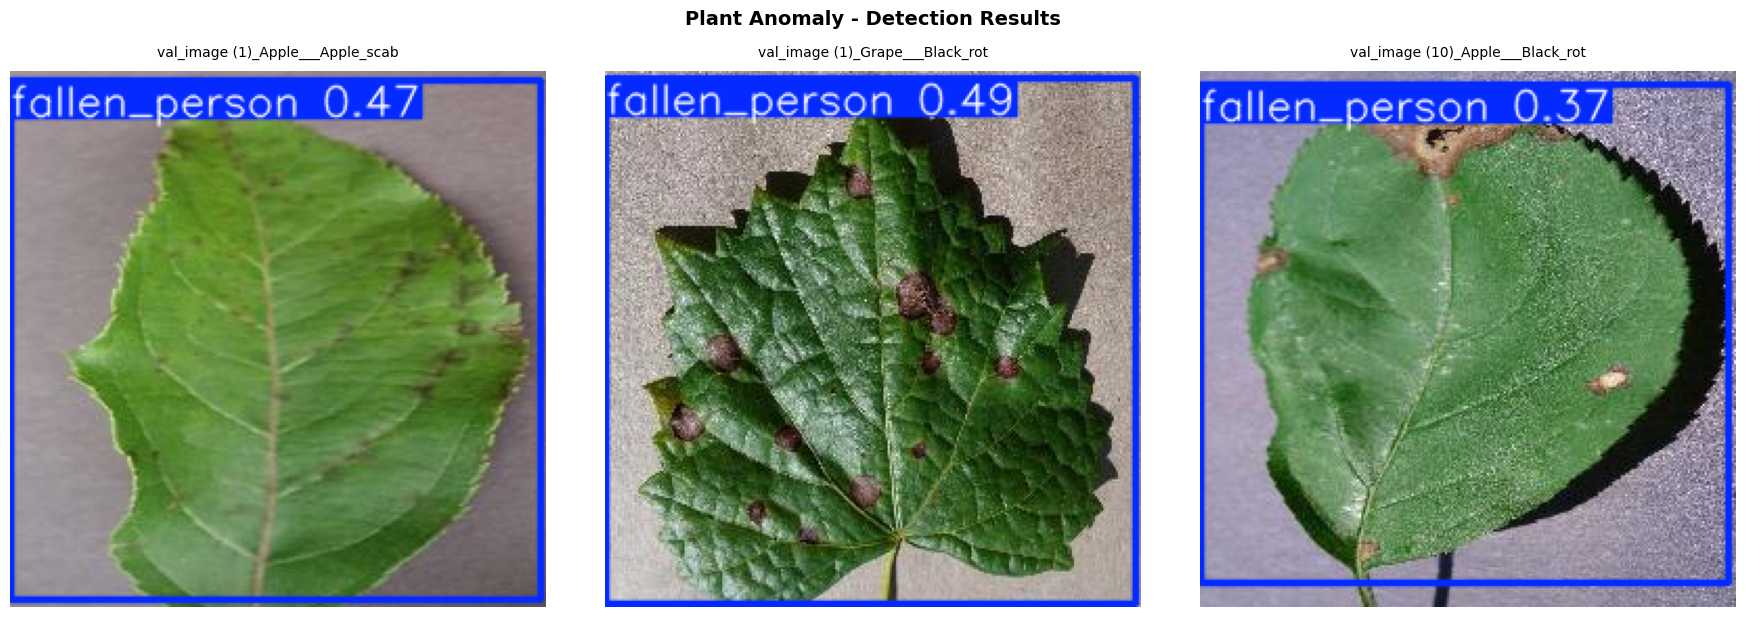


📊 Plant Anomaly Detections:
   1. val_image (1)_Apple___Apple_scab.jpg:
      • fallen_person: 46.6%
   2. val_image (1)_Grape___Black_rot.jpg:
      • fallen_person: 49.3%
   3. val_image (10)_Apple___Black_rot.jpg:
      • fallen_person: 37.4%


In [20]:
# Dataset configuration
DATASETS = {
    'plants': {'path': 'yolo_anomaly_dataset/data.yaml', 'name': 'Plant Anomaly'}
}

def show_predictions(model, yaml_path, dataset_name, num_samples=3, conf_threshold=0.3):
    """Display predictions from validation set"""
    with open(yaml_path, 'r') as f:
        config = yaml.safe_load(f)
    
    val_path = Path(config['val'])
    all_images = list(val_path.glob('*.[jp][pn][g]*'))
    
    if not all_images:
        print(f"⚠️  No validation images found in {val_path}")
        return
    
    # Filter for images with detections
    good_results = []
    for img_path in all_images[:50]:  # Check more images
        results = model(str(img_path), verbose=False, conf=conf_threshold)
        boxes = results[0].boxes
        if len(boxes) > 0:
            good_results.append((img_path, results[0]))
        if len(good_results) >= num_samples:
            break
    
    if not good_results:
        # Show images anyway, even without detections
        print(f"ℹ️  No detections above {conf_threshold:.0%} confidence. Showing sample images...")
        good_results = [(img, model(str(img), verbose=False, conf=0.1)[0]) 
                       for img in all_images[:num_samples]]
    
    # Display results
    fig, axes = plt.subplots(1, len(good_results), figsize=(18, 6))
    if len(good_results) == 1:
        axes = [axes]
    
    for ax, (img_path, result) in zip(axes, good_results):
        annotated = result.plot()
        annotated = cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB)
        ax.imshow(annotated)
        ax.set_title(f"{img_path.stem}", fontsize=10, pad=10)
        ax.axis('off')
    
    plt.suptitle(f'{dataset_name} - Detection Results', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    # Print detection summary
    print(f"\n📊 {dataset_name} Detections:")
    for i, (img_path, result) in enumerate(good_results, 1):
        boxes = result.boxes
        if len(boxes) > 0:
            print(f"   {i}. {img_path.name}:")
            for box in boxes:
                cls = int(box.cls[0])
                conf = float(box.conf[0])
                print(f"      • {model.names[cls]}: {conf:.1%}")
        else:
            print(f"   {i}. {img_path.name}: No detections")

# Show Plant Anomaly Detection results
show_predictions(model, DATASETS['plants']['path'], 'Plant Anomaly', num_samples=3, conf_threshold=0.25)


## 3. Model Validation Metrics

In [21]:
# Validate on Plant Anomaly dataset
print("="*60)
print("MODEL PERFORMANCE METRICS")
print("="*60)

# Plant Anomaly Detection
print("\n🌱 Plant Anomaly Detection:")
metrics_plants = model.val(data=DATASETS['plants']['path'], verbose=False)
print(f"   mAP50:    {metrics_plants.box.map50:.3f}")
print(f"   mAP50-95: {metrics_plants.box.map:.3f}")
print(f"   Precision: {metrics_plants.box.mp:.3f}")
print(f"   Recall:    {metrics_plants.box.mr:.3f}")

print("\n" + "="*60)


MODEL PERFORMANCE METRICS

🌱 Plant Anomaly Detection:
Ultralytics 8.3.204  Python-3.12.4 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 2050, 4096MiB)
val: Fast image access  (ping: 0.00.0 ms, read: 182.894.4 MB/s, size: 12.7 KB)
val: Fast image access  (ping: 0.00.0 ms, read: 182.894.4 MB/s, size: 12.7 KB)
val: Scanning C:\Users\ASUS\Desktop\personal Projects\wieact\yolo_anomaly_dataset\val\labels.cache... 6453 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 6453/6453 6.5Mit/s 0.0s
val: Scanning C:\Users\ASUS\Desktop\personal Projects\wieact\yolo_anomaly_dataset\val\labels.cache... 6453 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 6453/6453 6.5Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 404/404 4.9it/s 1:22<0.2ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 404/404 4.9it/s 1:22
                   all       6453       6453      0.973      0.

## 4. Export Model (Optional)

In [ ]:
# Export to ONNX format for deployment
# model.export(format='onnx')
print("💡 To export: Uncomment the line above and run this cell")